# Optics of the *M. amalphitanum* eye
- View ommatidia measurements from AM and team 
- Calculate optical parameters from physical measurements
- Perform clustering on these physical features, compare with lamina circuit clustering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os.path
import json
from typing import Tuple
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import mannwhitneyu

from cx_analysis.utils import index_by_om, yymmdd_today
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm
from cx_analysis.vis.hex_lattice import hexplot_TEST, hexplot, om_to_hex

In [3]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs=False
fig_path = os.path.expanduser(f'~/Dropbox (Simons Foundation)/lamina_figures/{yymmdd_today()}_')
##################
# if save_figs:
#     fig.savefig(fig_path + fname + '.svg')
#     fig.savefig(fig_path + fname + '.png')

In [4]:
tp = '210809'
data_path = f'~/Data/{tp}_lamina/'  
replace_with_left = True

In [5]:
optics_df = pd.read_excel(data_path + 'optics/1911_anastasia_om_measurements.xlsx', index_col=0)
optics_df = optics_df.iloc[1:-2] # remove last two lines of excel file

# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rh_len = pd.read_pickle(data_path + 'optics/201123_rh_len_df.pickle')
for i, v in rh_len.iterrows():
    optics_df.loc[i, 'rhabdom_len'] = float(v)

### Replace manual curvature measurements with JP's ###
optics_df = optics_df.drop(['outer curvature', 'inner curvature'], axis=1)
with open(os.path.expanduser(data_path + 'optics/210723_jp_optics_measurements.json')) as fh:
    jp_data = json.load(fh)

right_om_labels = {'A0': 73, 'B0': 72, 
                  'A1': 71, 'B1': 70, 'C1': 69, 
                  'A2': 68, 'B2': 67, 'C2': 66, 'D2': 65, 
                  'A3': 64, 'B3': 63, 'C3': 61, 'D3': 62, 
                  'A4': 60, 'B4': 57, 'E4': 59,  
                  'A5': 56, 'B5': 55, 'C5': 54, 'D5': 53,
                  'B6': 52, 'E6': 51}

r_in = []
r_out = []
lens_centers_in = {}
lens_centers_out = {}
for om in optics_df.index:
    if om in right_om_labels.keys():
        r_in.append(jp_data['radii_in'][str(right_om_labels[om])])
        r_out.append(jp_data['radii_out'][str(right_om_labels[om])])
        lens_centers_in[om] = np.array(jp_data['centers_in'][str(right_om_labels[om])])
        lens_centers_out[om] = np.array(jp_data['centers_out'][str(right_om_labels[om])])
                                    
    else:
        r_in.append(np.nan)
        r_out.append(np.nan)
# Convert radii and center coordinates to microns
optics_df.loc[:, 'radius_in'] = np.array(r_in) / 1000.0
optics_df.loc[:, 'radius_out'] = np.array(r_out) / 1000.0 
lens_centers_in = pd.Series(lens_centers_in, dtype='object', name='lens_centers_in') / 1000.0
lens_centers_out = pd.Series(lens_centers_out, dtype='object', name='lens_centers_out') / 1000.0

In [6]:
def dist_from_centers(ind):
    in_coord = np.array(jp_data['centers_in'][ind])
    out_coord = np.array(jp_data['centers_out'][ind])
    dist = np.linalg.norm(in_coord - out_coord)
    display(dist)
    return dist  # nanometers

if replace_with_left:
    left_right_error = dict()
    left_om_labels = {'A0': 12, 'B0': 19, 
                 'A1': 11, 'B1': 21, 'C1': 26,
                 'A2': 7, 'B2': 17, 'C2': 24, 'D2': 28, 
                 'A3': 4, 'B3': 15, 'C3': 23, 'D3': 29, 
                 'A4': 2, 'B4': 10, 'C4': 18, 'D4': 25, 'E4': 27, 
                 'A5': 1, 'B5': 6, 'C5': 14, 'D5': 20, 'E5': 22, 
                 'B6': 3, 'C6': 9, 'D6': 13, 'E6': 16, 
                 'D7': 5, 'E7': 8}
    for om in optics_df.index:
        left_i = str(left_om_labels[om])
        if om not in right_om_labels.keys():
            # use measurement from left eye
            optics_df.loc[om, 'radius_in'] = jp_data['radii_in'][left_i] / 1000.0 * -1.0
            optics_df.loc[om, 'radius_out'] = jp_data['radii_out'][left_i] / 1000.0
            
            # calculate thickness
            optics_df.loc[om, 'lens_thickness'] = dist_from_centers(left_i) / 1000.0
            
        else:
            # use left/right average
            right_i = str(right_om_labels[om])
            optics_df.loc[om, 'radius_in'] = (jp_data['radii_in'][left_i] + jp_data['radii_in'][right_i])/ 2.0 / 1000.0 * -1.0
            optics_df.loc[om, 'radius_out'] = (jp_data['radii_out'][left_i] + jp_data['radii_out'][right_i])/ 2.0 / 1000.0
            optics_df.loc[om, 'lens_thickness'] = (dist_from_centers(left_i) + dist_from_centers(right_i)) / 2.0 / 1000.0

display(optics_df.describe().round(2))

1822.9042764563499

3413.9278094062556

741.7603815960381

4518.354059793307

4656.233527579068

3989.3725021331934

1799.1889657899837

1438.8722968829024

3455.3372433918094

1448.7869985489697

1605.7549860574086

2662.6818372227567

4499.827077715809

3086.159421792861

4055.7854063324075

785.6286651423189

3893.8260394772824

3876.129644800333

3448.009658152756

1135.193398281378

5044.769955459503

2343.275977294414

5049.986817104545

2322.7680077602095

4830.460263931288

1981.480518473576

1828.1842821292887

2213.400336666189

2327.81250444588

3703.6973343700242

3323.4744379610925

2995.2909724621295

4363.157469230485

2521.542961907916

4952.91147674006

3501.3376699865335

4215.260629983529

2230.00768174561

4609.659229689438

1842.4710867127715

1898.9079908204824

3849.5904330960448

3092.8626815135567

4036.481999521469

5039.894869388294

4315.038381014489

4569.274404886179

3352.7418086125485

4814.511140935859

4111.7930009670445

5515.746172860593

,lense thickness,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len,radius_in,radius_out,lens_thickness
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00
mean,3.01,4.07,6.04,2.49,1.89,26.79,14.26,-2.55,3.48,3.15
std,0.59,0.93,0.97,0.41,0.45,9.32,1.56,0.75,0.89,1.09
min,1.89,2.37,4.14,1.78,1.17,7.81,11.09,-3.85,1.34,0.79
25%,2.65,3.34,5.52,2.14,1.45,18.09,13.31,-2.99,2.61,2.08
50%,3.02,4.34,6.45,2.52,2.04,26.41,13.98,-2.65,3.65,3.51
75%,3.48,4.73,6.73,2.85,2.27,33.77,14.88,-2.38,4.20,3.86
max,4.19,6.10,7.20,3.10,2.45,42.78,18.25,-1.12,4.47,4.81


## Lens calculations
### Measurements (all $\mu{m}$)
- Lens: Outer radius of curvature, $r_1$
- Lens: Inner radius of curvature, $r_2$
- Lens: thickness, $t$
- Lens: diameter, $D$
- Rhabdom: distal diameter, $D_{Rh}$
- Rhabdom: length, $l_{Rh}$
- Measurements also taken for the length and distal width of the crystalline cone, and the proximal diameter of the rhabdom (not used for the following calculations) 

### Calculations
- We used the refractive indices of the honey bee lens ($n_l$) and crystalline cone ($n_c$), from Valera & Wiitanen (1970)
- Equivalent power of a thick lens ($\mu{m}^{-1}$) $P_{eq}$, calculated using the thick lens formula (Fundamentals of Optics, Jenkins & White, p.84, 2001): 
$$P_{eq} = P_1 + P_2 - \frac{t}{n_l} P_1 P_2$$
    - $P_1 = \frac{n_l - 1.0}{r_1}$, power from outer lens surface (air->lens)
    - $P_2 = \frac{n_c - n_l}{r_2}$, power from inner lens surface (lens->cone) 
- Focal length of the object ($\mu{m}$): $f = 1/P$
- Focal length of the image ($\mu{m}$): $f' = {n_c}/P$

- Outer and inner principle planes ($\mu{m}$): 
$$e_{out} = (t\frac{n_0}{n_l})(\frac{P_2}{P_{eq}})$$
$$e_{in} = -(t\frac{n_c}{n_l})(\frac{P_1}{P_{eq}})$$


- Back focal distance ($\mu{m}$): BFD = $BFD = f'(1 - \frac{(n_l-n_c)t}{n_lr_1})$
- F-number: $F = f/D$
- The acceptance angle of an ommatidium, $\Delta\rho$, is proscribed by diffraction effects at the lens,  $\Delta\rho_l$, and the geometry of the distal rhabdom tip and the lens, $\Delta\rho_{Rh}$ (Snyder, 1979):
$$\Delta\rho = \sqrt{{\Delta\rho_l}^2 + {\Delta\rho_{Rh}}^2}$$
    - $\Delta\rho_l = \lambda/D$, where we set $\lambda$ = 0.5 $\mu{m}$ (green monochromatic light)
    - $\Delta\rho_{Rh} = D_{Rh}/f$
- Optical sensitivity to an extended broadband-spectrum source, $S$ ($\mu{m}^2{sr}$), approximated by:  
$$S = (\frac{\pi}{4})^2 D^2 {\Delta\rho}^2 \frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$$
    - See [Fredriksen and Warrant, 2008](https://dx.doi.org/10.1098%2Frsbl.2008.0467); [Kirschfeld, 1974](https://doi.org/10.1515/znc-1974-9-1023)
    - k is the peak absorbtion (length) coefficient of the visual pigment, taken as 0.0067 $\mu{m}^-1$ (Warrant et al., 2004)
    - Notes: facet area is $\frac{\pi{D}^2}{4}$, the fraction of incident light absorbed is $\frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$



In [7]:
# refraction indices
n0 = 1.0    # air
nl = 1.452  # lens
nc = 1.348  # crys cone

def power_terms(r_outer: float, r_inner: float, thin_approx: bool=False, t: float=0.0) -> float:
    
    # Check sign convention 
    assert(r_outer >= 0.0)  # Outer is positive
    assert(r_inner <= 0.0)  # Inner is negative

    p1 = (nl - 1.0)/r_outer # interface air->lens 
    p2 = (nc - nl)/r_inner # interface lens->cone
    if thin_approx:
        return p1, p2
    else:
        if t == 0.0:
            raise ValueError("t must be passed if thin_approx=False (the default option)")
        else:
            p3 = (t/nl) * p1 * p2
            return p1, p2, p3

        
def focal_length(r_outer: float, r_inner: float, thin_approx: bool=False, t: float=0.0) -> float:
    
    if thin_approx:
        p1, p2 = power_terms(r_outer, r_inner)
        return 1.0/(p1 + p2)
    else:
        p1, p2, p3 = power_terms(r_outer, r_inner, t=t)
        print(p2)
        return 1.0/(p1 + p2 - p3)


def principle_plane_dist(r_outer: float, r_inner: float, t: float) -> Tuple:
    # Requires t, lens thickness
    p1, p2, p3 = power_terms(r_outer, r_inner, t=t)
    equiv_power = p1 + p2 - p3
    e_front = (n0 * t / nc) * (p2/equiv_power)
    e_back = -1.0 * (nl * t / nc) * (p1/equiv_power)
    
    return e_front, e_back

        
def back_focal_distance(im_focal_len: float, r_outer: float, lens_thickness: float) -> float:
    
    # Check sign convention 
    assert(r_outer > 0.0)  # Outer is positive
    
    #principle = ((nl - nc) * lens_thickness)/(nc * r_outer)
    principle = ((nl - nc) * lens_thickness)/(nc * r_outer)
    bfd = im_focal_len * (1.0 - principle)
    
    return bfd


def acceptance_angle(D, Dr, f): # lens diameter, distal rhabdom diameter, focal length
    # Acceptance angle
    rho_l = 0.5/D # angular sens. due to diffraction at the lens, 500nm light
    rho_rh = Dr/f # angular sens. due to geometry of rhabdom tip
    # 'simple' acceptance angle formula 
    rho = (rho_l ** 2.0 + rho_rh ** 2.0) ** (0.5)
    
    return rho_l, rho_rh, rho # radians

In [8]:
r_out = optics_df['radius_out']
r_in = optics_df['radius_in']
#l_thick = optics_df['lense thickness']   # lense thickness is for AM's manual measurements
l_thick = optics_df['lens_thickness'] # lens_thickness uses distance computed from lens centers 
D = optics_df['lense diameter (stack)'].astype('float')
Dr = optics_df['D rhabdom dist.']
lr = optics_df['rhabdom_len']
# focal length
f = np.array([focal_length(r_outer=r1, r_inner=r2, t=t) for r1, r2, t in zip(r_out, r_in, l_thick)])
fi = f * 1.348
bfd = np.array([back_focal_distance(this_f, r_outer, t) for this_f, r_outer, t in zip(fi, r_out, l_thick)])  
e_front, e_back = np.array([principle_plane_dist(r1, r2, t) for r1, r2, t in zip(r_out, r_in, l_thick)]).T
# Acceptance angle
# will be converted rad->deg when added to optics_df
# rho = (rho_l ** (2.0) + rho_rh ** (2.0)) ** (0.5)
rho_l, rho_rh, rho = acceptance_angle(D, Dr, f)
# Optical sensitivity
k = 0.0067 # peak absorbtion coefficient (wrt rhabdom length) from Warrant et al., 2004
kl = k * lr
S = ((np.pi / 4.0)**2.0) * (D ** 2.0) * (rho ** 2.0) * (kl / (2.3 + kl))

optics_df['f'] = f.astype('float') 
optics_df['f-image'] = fi.astype('float') 
optics_df['P'] = (1.0/f).astype('float') 
optics_df['bfd'] = bfd.astype('float') 
optics_df['e_front'] = e_front.astype('float')
optics_df['e_back'] = e_back.astype('float')
optics_df['rho_l'] = np.degrees(rho_l.astype('float') )
optics_df['rho_rh'] = np.degrees(rho_rh.astype('float') )
optics_df['rho'] = np.degrees(rho.astype('float') )
optics_df['S'] = S.astype('float')  

display(optics_df[['rho_l', 'rho_rh', 'rho']])
display(optics_df.describe().round(2))
#optics_df.to_csv(f'~/Data/{tp}_lamina/{tp}_optics.csv' )

0.08131475965767372
0.04266374656309982
0.03091289147654999
0.02955168591232337
0.0674081896818935
0.0724381959398566
0.03983321989258162
0.04213516695512112
0.04375367069879707
0.03641982221325241
0.0930029388990847
0.03927447080524638
0.03932796544201886
0.037033286222332124
0.039620626447140664
0.03262525094294549
0.08622547751022441
0.057698632737635556
0.04111972656331405
0.03709395117730424
0.03905302652004765
0.038868852959739845
0.034800255759208545
0.06908506572851955
0.03382856045798397
0.027030445158127407
0.03239398432549323
0.036373953821297225
0.0276847525795506


,rho_l,rho_rh,rho
E7,4.138074,26.513166,26.834151
E6,4.103853,26.659250,26.973268
E5,3.092723,17.670754,17.939355
E4,3.546598,25.431026,25.677139
D7,4.479032,29.350541,29.690335
D6,3.960173,28.620504,28.893186
D5,3.508741,23.803365,24.060578
D4,3.568496,35.374750,35.554284
D3,3.958148,24.229367,24.550543
D2,3.906026,25.444439,25.742504


,lense thickness,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len,radius_in,radius_out,lens_thickness,f,f-image,P,bfd,e_front,e_back,rho_l,rho_rh,rho,S
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00
mean,3.01,4.07,6.04,2.49,1.89,26.79,14.26,-2.55,3.48,3.15,6.25,8.42,0.18,7.83,0.61,-2.76,3.81,24.14,24.45,0.26
std,0.59,0.93,0.97,0.41,0.45,9.32,1.56,0.75,0.89,1.09,1.62,2.19,0.07,1.99,0.21,1.01,0.49,6.40,6.38,0.12
min,1.89,2.37,4.14,1.78,1.17,7.81,11.09,-3.85,1.34,0.79,2.42,3.26,0.12,3.12,0.13,-4.46,3.09,16.17,16.46,0.13
25%,2.65,3.34,5.52,2.14,1.45,18.09,13.31,-2.99,2.61,2.08,4.82,6.49,0.13,6.08,0.43,-3.27,3.51,20.87,21.14,0.19
50%,3.02,4.34,6.45,2.52,2.04,26.41,13.98,-2.65,3.65,3.51,6.73,9.07,0.15,8.41,0.63,-3.07,3.75,23.27,23.64,0.23
75%,3.48,4.73,6.73,2.85,2.27,33.77,14.88,-2.38,4.20,3.86,7.61,10.26,0.21,9.59,0.79,-1.89,4.10,25.44,25.74,0.28
max,4.19,6.10,7.20,3.10,2.45,42.78,18.25,-1.12,4.47,4.81,8.08,10.89,0.41,10.05,0.87,-0.69,5.02,48.69,48.91,0.70


## Interommatidial distances

In [9]:
def hex_distance(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return np.linalg.norm(c1-c2)

pairs = list(itertools.combinations(lens_centers_out.index, 2))

ret_dist = []
hex_dist = []
for o1, o2 in pairs:
    ret_dist.append(np.linalg.norm(lens_centers_out[o1] - lens_centers_out[o2]))
    hex_dist.append(hex_distance(o1, o2))

pair_dist = pd.DataFrame(data=np.transpose([ret_dist, hex_dist]), columns=['ret_dist', 'hex_dist'], index=pairs)
print((pair_dist['ret_dist'] / pair_dist['hex_dist']).describe())
print(pair_dist.loc[pair_dist['hex_dist'] <= 1.1, 'ret_dist'].describe())


count    231.000000
mean       8.504175
std        1.264842
min        5.354791
25%        7.805049
50%        8.493867
75%        9.109067
max       15.897470
dtype: float64
count    41.000000
mean      8.920935
std       2.106250
min       5.791004
25%       7.710840
50%       8.196163
75%       9.771404
max      15.897470
Name: ret_dist, dtype: float64


In [10]:
# check that Drh/f
np.mean(np.degrees((optics_df['D rhabdom dist.']/optics_df['f'])))
# rho = sqrt((Drh/f)**2 + (lambda/Dlens)**2)
Drh = optics_df.loc[:, 'D rhabdom dist.']
f = optics_df.loc[:, 'f']

wavelen = 0.500
Dlens =  optics_df.loc[:, 'lense diameter (stack)'].astype('float')

rhorh_rhol_acceptance = pd.DataFrame(data={'Drh/f': np.degrees(Drh/f), 
                                           '0.5/Dlens': np.degrees(wavelen/Dlens), 
                                           'Acceptance (deg.)': np.degrees(((Drh/f)**2.0 + (wavelen/Dlens)**2.0) ** 0.5)})
display(rhorh_rhol_acceptance.describe())

,Drh/f,0.5/Dlens,Acceptance (deg.)
count,29.000000,29.000000,29.000000
mean,24.140788,3.807623,24.449423
std,6.404737,0.491298,6.383226
min,16.170578,3.092723,16.464669
25%,20.872371,3.508741,21.142857
50%,23.265744,3.745963,23.644662
75%,25.444439,4.103853,25.742504
max,48.691832,5.024985,48.906280


In [11]:
# slope ~= 1/rho_rh
one_over_slope = np.array([1.0/3.2] * len(optics_df.index))

rhorh_rhol_acceptance = pd.DataFrame(data={'one_over_slope': np.degrees(one_over_slope), 
                                           '0.5/Dlens': np.degrees(wavelen/Dlens), 
                                           'Acceptance (deg.)': np.degrees(((one_over_slope)**2.0 + (wavelen/Dlens)**2.0) ** 0.5)})

#display(rhorh_rhol_acceptance)
display(rhorh_rhol_acceptance.describe())

,one_over_slope,0.5/Dlens,Acceptance (deg.)
count,2.900000e+01,29.000000,29.000000
mean,1.790493e+01,3.807623,18.311386
std,3.615598e-15,0.491298,0.105475
min,1.790493e+01,3.092723,18.170071
25%,1.790493e+01,3.508741,18.245488
50%,1.790493e+01,3.745963,18.292589
75%,1.790493e+01,4.103853,18.369218
max,1.790493e+01,5.024985,18.596694


In [12]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
ndra_om = [str(o) for o in optics_df.index if o not in dra_om]
optics_df['region'] = ['dra' if (om in dra_om) else 'ndra' for om in optics_df.index]
display(optics_df.groupby('region').describe().T)#.loc[:, ['mean', 'std']])#.loc['mean'])
display(optics_df.groupby('region').describe().T.loc['bdf'])#.loc[:, ['mean', 'std']])#.loc['mean'])

for p, data in optics_df.groupby('region').describe().items():
    display(p)
    display(data)
    
#optics_df.groupby('region').describe().to_excel("220203_dra-ndra.xlsx")
# regional_summary = pd.DataFrame([optics_df.mean(), optics_df.std(ddof=0), 
#                                  optics_df.loc[ndra_om].mean(), optics_df.loc[ndra_om].std(ddof=0), 
#                                  optics_df.loc[dra_om].mean(), optics_df.loc[dra_om].std(ddof=0)], 
#                                 index=['All_mean', 'All_SD', 'NDRA_mean', 'NDRA_SD', 'DRA_mean', 'DRA_SD'])

region                       dra       ndra
lense thickness count  10.000000  19.000000
                mean    2.506986   3.279893
                std     0.562660   0.399648
                min     1.886340   2.652850
                25%     2.039522   2.963160
...                          ...        ...
S               min     0.133857   0.158552
                25%     0.184342   0.204543
                50%     0.231219   0.227066
                75%     0.262929   0.279984
                max     0.697002   0.591290

[160 rows x 2 columns]

KeyError: 'bdf'

In [25]:
region_mean_table = []
#params_to_include = ['cone length (from the tip)', 'cone width (under the lense tip)', 'D rhabdom dist.', 'rhabdom_len', 'radius_in', 'radius_out', 'lens_thickness', '']


for param, values in optics_df.iteritems():
    if param == 'region':
        continue
    else:
        global_mean = values.mean()
        dra_mean = values[optics_df['region'] == 'dra'].mean()
        ndra_mean = values[optics_df['region'] == 'ndra'].mean()
        
        global_std = values.std(ddof=0)
        dra_std = values[optics_df['region'] == 'dra'].std(ddof=0)
        ndra_std = values[optics_df['region'] == 'ndra'].std(ddof=0)
        
        
        if dra_mean > ndra_mean:
            U, p = mannwhitneyu(values[optics_df['region'] == 'dra'], 
                                 values[optics_df['region'] == 'ndra'], alternative='greater')
        else:
            U, p = mannwhitneyu(values[optics_df['region'] == 'dra'], 
                                 values[optics_df['region'] == 'ndra'], alternative='less')
        
        
        region_mean_table.append([param, f"{global_mean: .2f}\u00B1{global_std: .2f}", 
                                         f"{dra_mean: .2f}\u00B1{dra_std: .2f}", 
                                         f"{ndra_mean: .2f}\u00B1{ndra_std: .2f}", U, p])

from prettytable import PrettyTable    

x = PrettyTable()
    
x.field_names = ['param', 'All', 'DRA', 'NDRA', 'U', 'p']
for r in region_mean_table:
    x.add_row(r)

print(x)
    
    
        

+----------------------------------+--------------+--------------+--------------+-------+------------------------+
|              param               |     All      |     DRA      |     NDRA     |   U   |           p            |
+----------------------------------+--------------+--------------+--------------+-------+------------------------+
|      lense diameter (stack)      |  7.64± 0.94  |  6.93± 0.85  |  8.02± 0.75  |  33.0 | 0.0023876467345586806  |
|         lense thickness          |  3.01± 0.58  |  2.51± 0.53  |  3.28± 0.39  |  27.0 | 0.0009770787903122912  |
|    cone length (from the tip)    |  4.07± 0.92  |  3.03± 0.36  |  4.62± 0.58  |  0.0  |  7.25635353423846e-06  |
| cone width (under the lense tip) |  6.04± 0.96  |  4.85± 0.63  |  6.66± 0.25  |  0.0  |  7.25635353423846e-06  |
|         D rhabdom dist.          |  2.49± 0.40  |  2.03± 0.16  |  2.73± 0.25  |  2.0  | 1.0969168094750653e-05 |
|         D rhabdom prox.          |  1.89± 0.44  |  1.31± 0.12  |  2.20± 0.15  

- Diffraction by the facet lens depends on light wavelength, lens diameter, and its focal distance
- Male blowfly, Calliphora (Stavenga 1990): D=20-40 $\mu{m}$; $f/D$ remains relatively constant despite range of D, giving $F = 2.0{\pm}0.2$ (based on optical measurements); 

## Distance between lens and rhabdom is linearly related to the focal length of the diopteric apparatus 

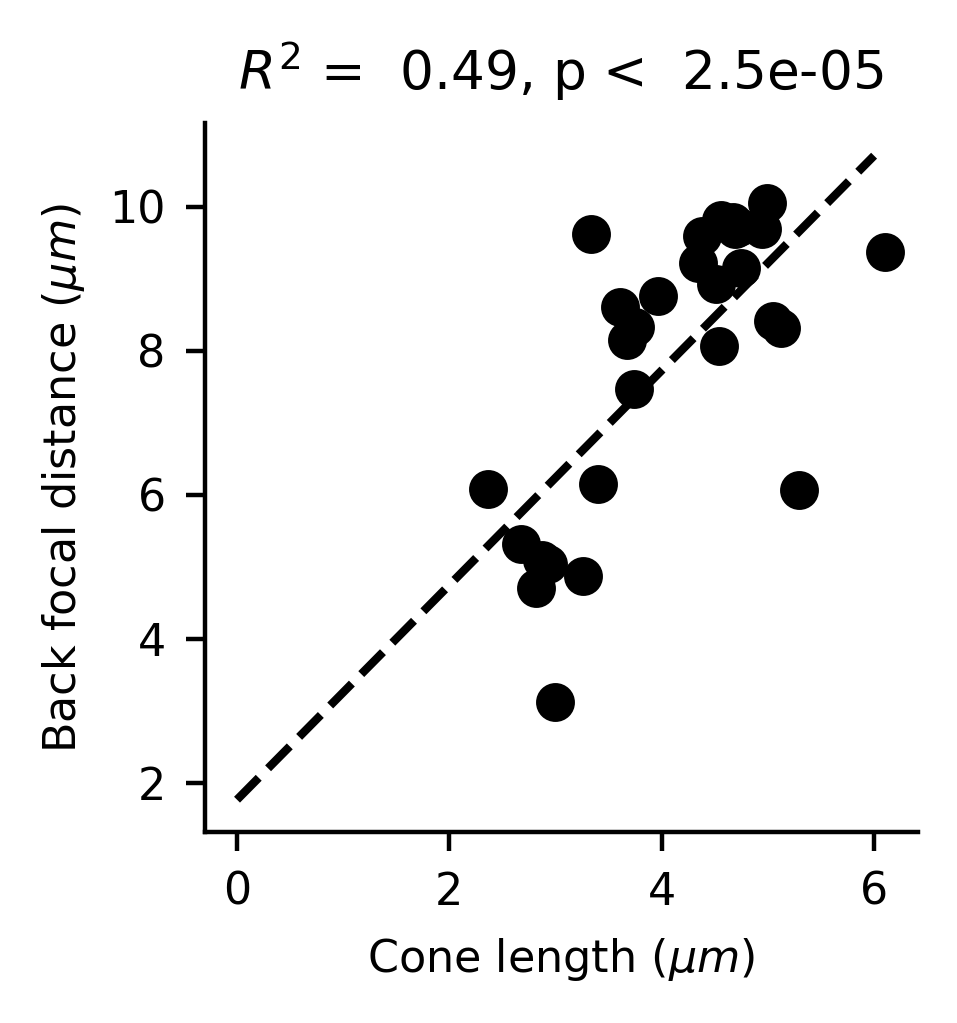

const                         1.763296
cone length (from the tip)    1.490803
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bfd   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     25.69
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           2.54e-05
Time:                        23:54:10   Log-Likelihood:                -50.892
No. Observations:                  29   AIC:                             105.8
Df Residuals:                      27   BIC:                             108.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.7633      1.227      1.437      0.162      -0.755       4.282
cone length (from the tip)     1.4908      0.294      5.068      0.000       0.887       2.094
==============================================================================
Omnibus:                        3.441   Durbin-Watson:                   2.430
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                2.224
Skew:                          -0.661   Prob(JB):                        0.329
Kurtosis:                       3.307   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
#Y = optics_df['f-image'] + optics_df['e_back'].dropna()  # e_back is neg.
Y = optics_df['bfd'].dropna()
_x = optics_df.loc[Y.index, 'cone length (from the tip)']
X = sm.add_constant(_x)


model = sm.OLS(Y, X)
results = model.fit()
params = results.params
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Cone length ($\mu{m}$)')
ax.set_ylabel("Back focal distance ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params['cone length (from the tip)'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.svg')
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.png')

# SHOW OLS RESULTS
display(params)
display(results.summary())

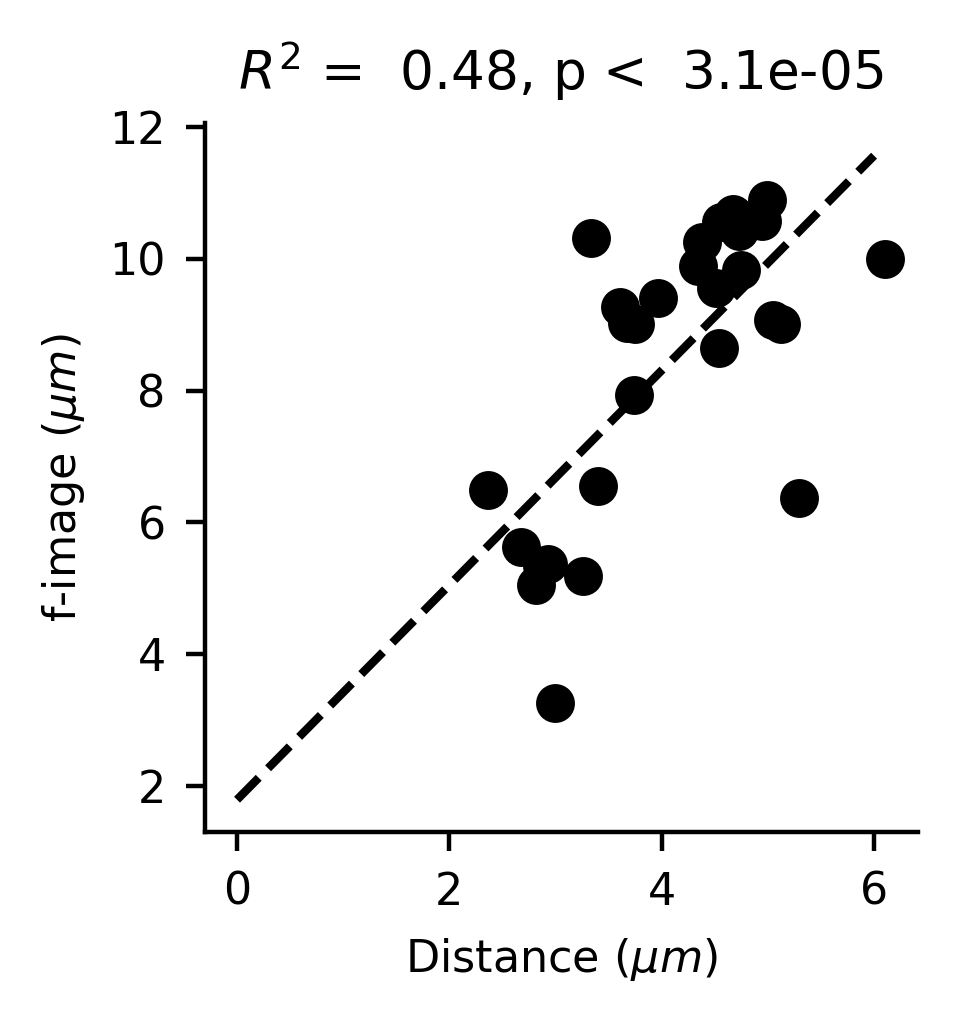

const                         1.794081
cone length (from the tip)    1.628077
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f-image   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     24.97
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           3.07e-05
Time:                        23:54:11   Log-Likelihood:                -53.856
No. Observations:                  29   AIC:                             111.7
Df Residuals:                      27   BIC:                             114.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.7941      1.360      1.320      0.198      -0.996       4.584
cone length (from the tip)     1.6281      0.326      4.997      0.000       0.960       2.297
==============================================================================
Omnibus:                        3.653   Durbin-Watson:                   2.387
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                2.432
Skew:                          -0.694   Prob(JB):                        0.296
Kurtosis:                       3.291   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
Y = optics_df['f-image'].dropna()
_x = optics_df.loc[Y.index, 'cone length (from the tip)']
X = sm.add_constant(_x)


model = sm.OLS(Y, X)
results = model.fit()
params = results.params
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Distance ($\mu{m}$)')
ax.set_ylabel("f-image ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params['cone length (from the tip)'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.svg')
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.png')

# SHOW OLS RESULTS
display(params)
display(results.summary())

In [14]:
optics_df.columns

Index(['lense diameter (stack)', 'lense thickness',
       'cone length (from the tip)', 'cone width (under the lense tip)',
       'D rhabdom dist.', 'D rhabdom prox.', 'Mean Microv. Ang. Turn',
       'rhabdom_len', 'radius_in', 'radius_out', 'lens_thickness', 'f',
       'f-image', 'P', 'bfd', 'e_front', 'e_back', 'rho_l', 'rho_rh', 'rho',
       'S', 'region'],
      dtype='object')

const    0.466814
0        1.020401
dtype: float64

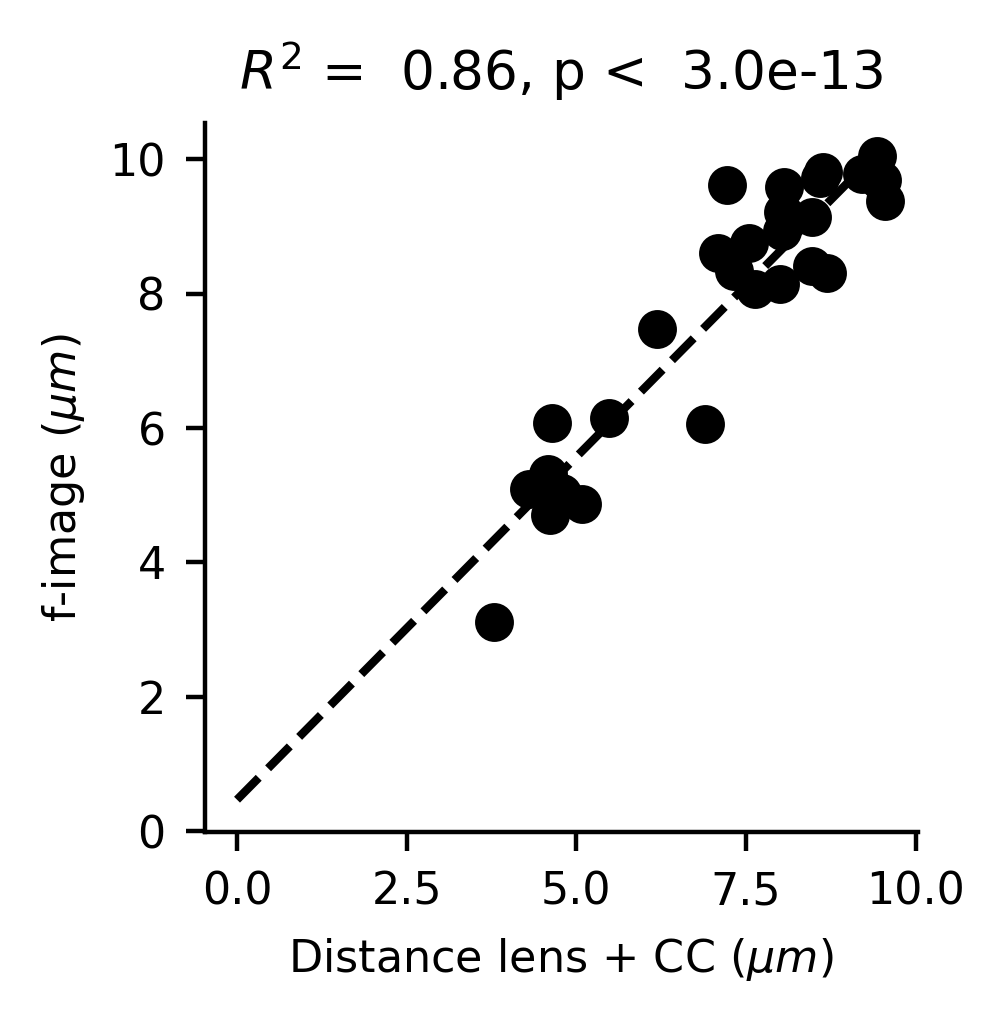

const    0.466814
0        1.020401
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bfd   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     172.8
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           3.00e-13
Time:                        23:54:16   Log-Likelihood:                -31.566
No. Observations:                  29   AIC:                             67.13
Df Residuals:                      27   BIC:                             69.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4668      0.577      0.809      0.426      -0.718       1.651
0              1.0204      0.078     13.144      0.000       0.861       1.180
==============================================================================
Omnibus:                        0.130   Durbin-Watson:                   2.764
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.110
Skew:                           0.110   Prob(JB):                        0.946
Kurtosis:                       2.793   Cond. No.                         31.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#Y = optics_df['f-image'].dropna()
Y = optics_df['bfd'].dropna()
_x = optics_df.loc[Y.index, 'cone length (from the tip)'] + optics_df.loc[Y.index, 'lens_thickness']
X = sm.add_constant(_x)


model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Distance lens + CC ($\mu{m}$)')
ax.set_ylabel("f-image ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params[0] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.svg')
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.png')

# SHOW OLS RESULTS
display(params)
display(results.summary())

# Focal length is also linearly related to the distal diameter of the rhabdom
- $D_{Rh} / f$ approximates the ommatidium's acceptance angle based on the geometry of the lens and rhabdom surface 

const             -0.167748
D rhabdom dist.    3.210976
dtype: float64

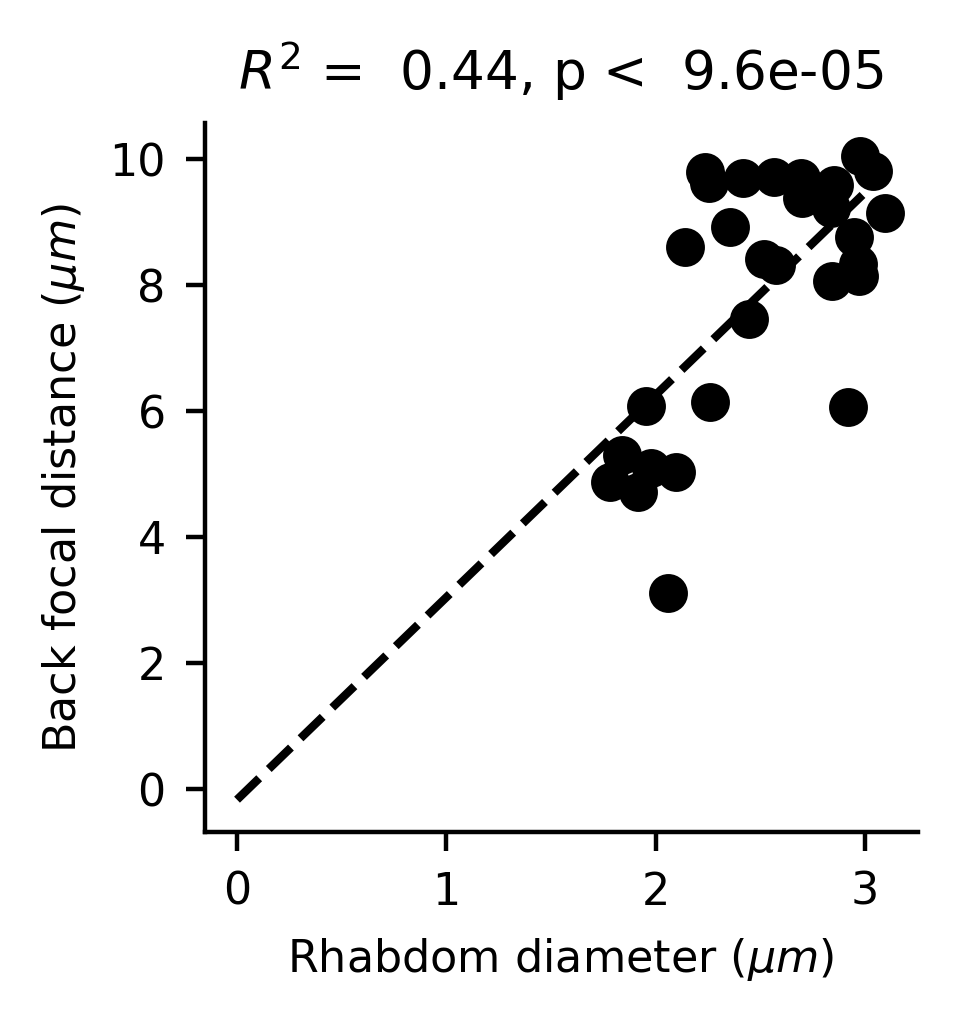

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bfd   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     20.91
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           9.59e-05
Time:                        13:49:42   Log-Likelihood:                -52.268
No. Observations:                  29   AIC:                             108.5
Df Residuals:                      27   BIC:                             111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1677      1.772     -0.095      0.925      -3.804       3.468
D rhabdom dist.     3.2110      0.702      4.573      0.000       1.770       4.652
==============================================================================
Omnibus:                        0.279   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.157
Skew:                          -0.165   Prob(JB):                        0.924
Kurtosis:                       2.854   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#Y = optics_df['f'].dropna()
Y = optics_df['bfd'].dropna()
_x = optics_df.loc[Y.index, 'D rhabdom dist.'] 
X = sm.add_constant(_x)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Rhabdom diameter ($\mu{m}$)')
ax.set_ylabel("Back focal distance ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'bfd_rhabdom-diam_scatter' + '.svg')
    fig.savefig(fig_path + 'bfd_rhabdom-diam_scatter' + '.png')

# SHOW OLS RESULTS
display(results.summary())

const             -0.355874
D rhabdom dist.    3.523139
dtype: float64

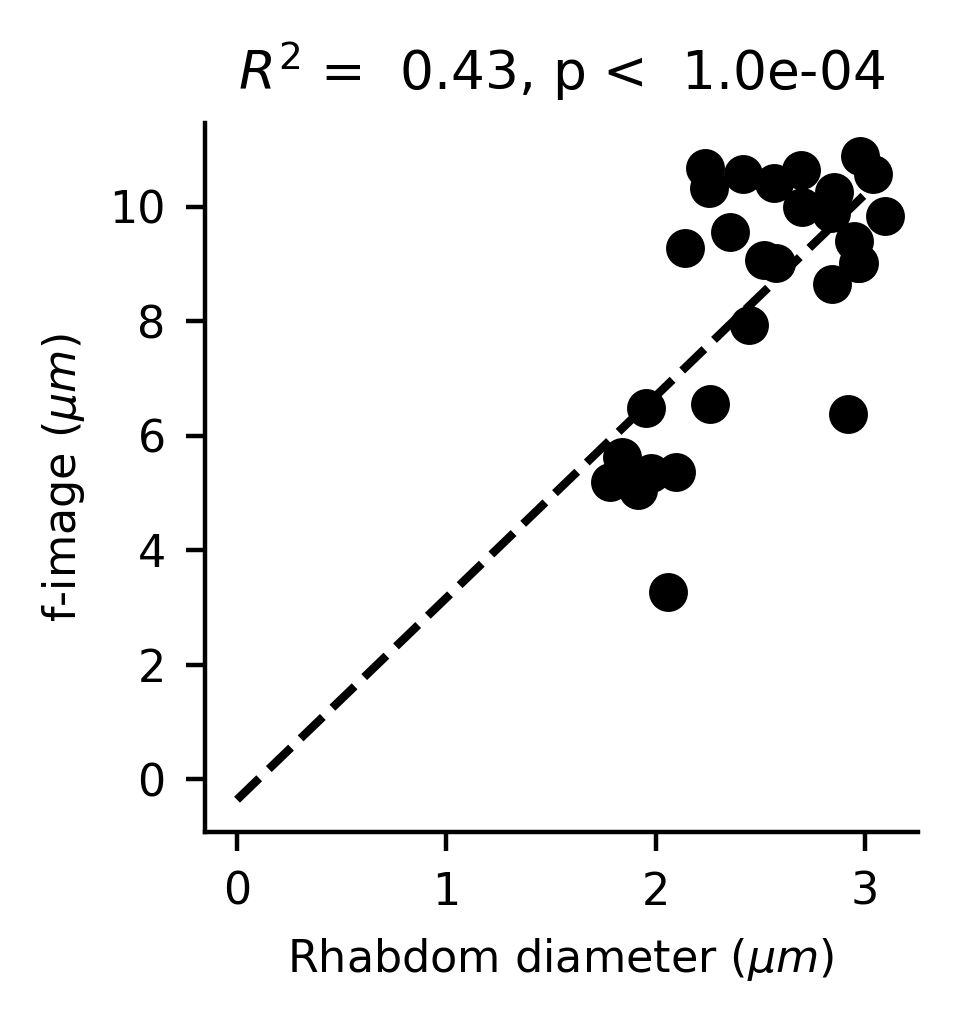

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f-image   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     20.72
Date:                Thu, 03 Feb 2022   Prob (F-statistic):           0.000101
Time:                        15:23:45   Log-Likelihood:                -55.093
No. Observations:                  29   AIC:                             114.2
Df Residuals:                      27   BIC:                             116.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3559      1.953     -0.182      0.857      -4.364       3.652
D rhabdom dist.     3.5231      0.774      4.552      0.000       1.935       5.111
==============================================================================
Omnibus:                        0.338   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.845   Jarque-Bera (JB):                0.121
Skew:                          -0.154   Prob(JB):                        0.941
Kurtosis:                       2.930   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
Y = optics_df['f-image'].dropna()
_x = optics_df.loc[Y.index, 'D rhabdom dist.'] 
X = sm.add_constant(_x)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Rhabdom diameter ($\mu{m}$)')
ax.set_ylabel("f-image ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'focal_rhabdom-diam_scatter' + '.svg')
    fig.savefig(fig_path + 'focal_rhabdom-diam_scatter' + '.png')

# SHOW OLS RESULTS
display(results.summary())

[0.20569515 0.1494414  0.16995281 0.14337713 0.14957788 0.1306147
 0.15582802 0.13631076 0.14955828 0.23962198 0.20766492 0.14096345
 0.13139349 0.13712931 0.12944472 0.14860585 0.25088667 0.14537469
 0.12617345 0.12378026 0.12762432 0.12663009]
[[ 1.         26.97326831]
 [ 1.         25.67713875]
 [ 1.         24.06057845]
 [ 1.         24.55054297]
 [ 1.         25.74250428]
 [ 1.         17.25342534]
 [ 1.         25.56906881]
 [ 1.         22.51329091]
 [ 1.         22.4734014 ]
 [ 1.         25.69910889]
 [ 1.         23.6446623 ]
 [ 1.         19.33564972]
 [ 1.         21.80699422]
 [ 1.         24.60671933]
 [ 1.         19.40572571]
 [ 1.         21.8282858 ]
 [ 1.         30.57583078]
 [ 1.         18.14158009]
 [ 1.         16.46466927]
 [ 1.         21.357889  ]
 [ 1.         22.48592958]
 [ 1.         19.90656919]]


array([-0.01418653,  0.00747442])

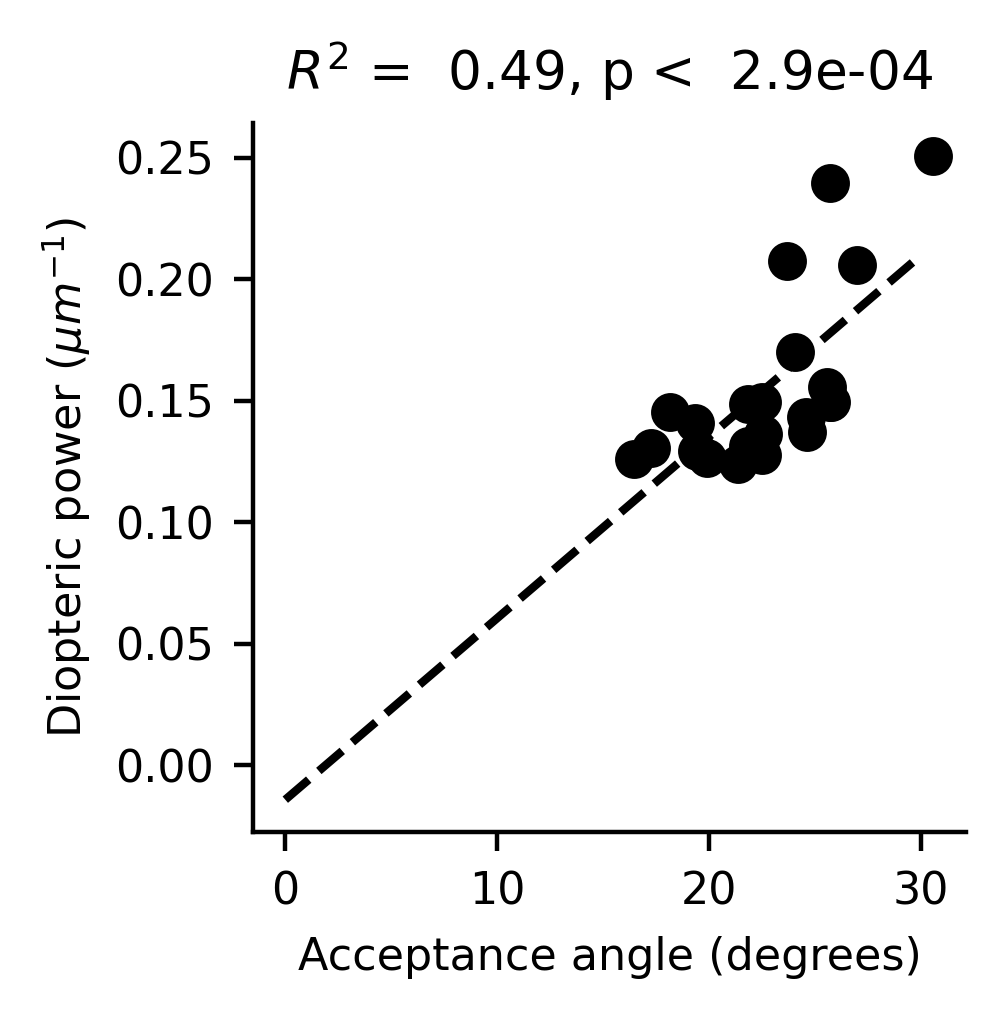

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     19.21
Date:                Thu, 03 Feb 2022   Prob (F-statistic):           0.000287
Time:                        15:22:55   Log-Likelihood:                 49.404
No. Observations:                  22   AIC:                            -94.81
Df Residuals:                      20   BIC:                            -92.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0142      0.039     -0.362      0.721      -0.096       0.068
x1             0.0075      0.002      4.383      0.000       0.004       0.011
==============================================================================
Omnibus:                        2.417   Durbin-Watson:                   1.312
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                1.911
Skew:                           0.700   Prob(JB):                        0.385
Kurtosis:                       2.643   Cond. No.                         157.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'f'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

print(np.asarray(Y))
print(X)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_ylabel('Diopteric power ($\mu{m}^{-1}$)')
ax.set_xlabel("Acceptance angle (degrees)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullscale.png')

# SHOW OLS RESULTS
display(results.summary())

array([-0.04540498,  0.00889635])

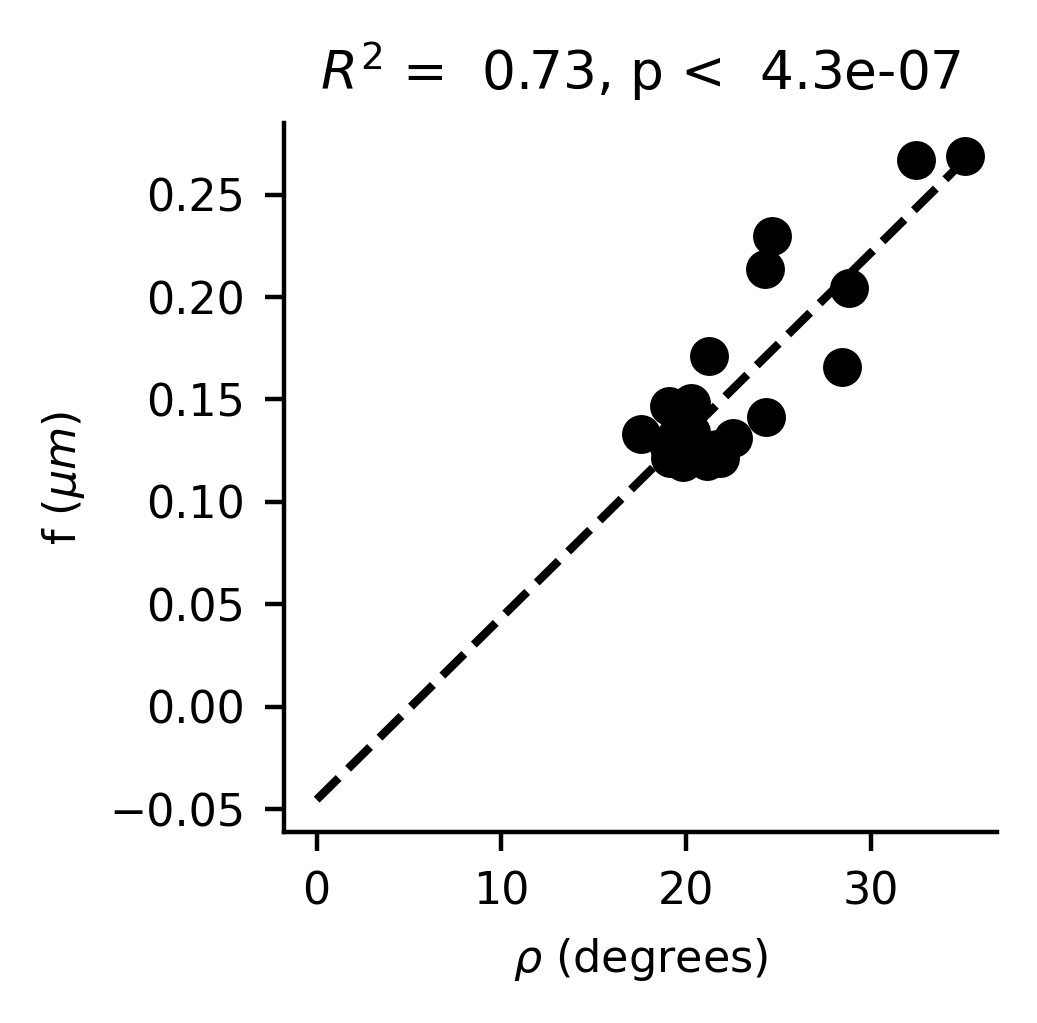

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     53.84
Date:                Mon, 24 Jan 2022   Prob (F-statistic):           4.31e-07
Time:                        14:01:05   Log-Likelihood:                 50.608
No. Observations:                  22   AIC:                            -97.22
Df Residuals:                      20   BIC:                            -95.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0454      0.028     -1.610      0.123      -0.104       0.013
x1             0.0089      0.001      7.338      0.000       0.006       0.011
==============================================================================
Omnibus:                        1.121   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.948
Skew:                           0.465   Prob(JB):                        0.622
Kurtosis:                       2.589   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'f'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel(r'$\rho$ (degrees)')
ax.set_ylabel("f ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig(fig_path + 'Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

array([0.09365537987814064, 0.0016822683359119632], dtype=object)

TypeError: No loop matching the specified signature and casting was found for ufunc add

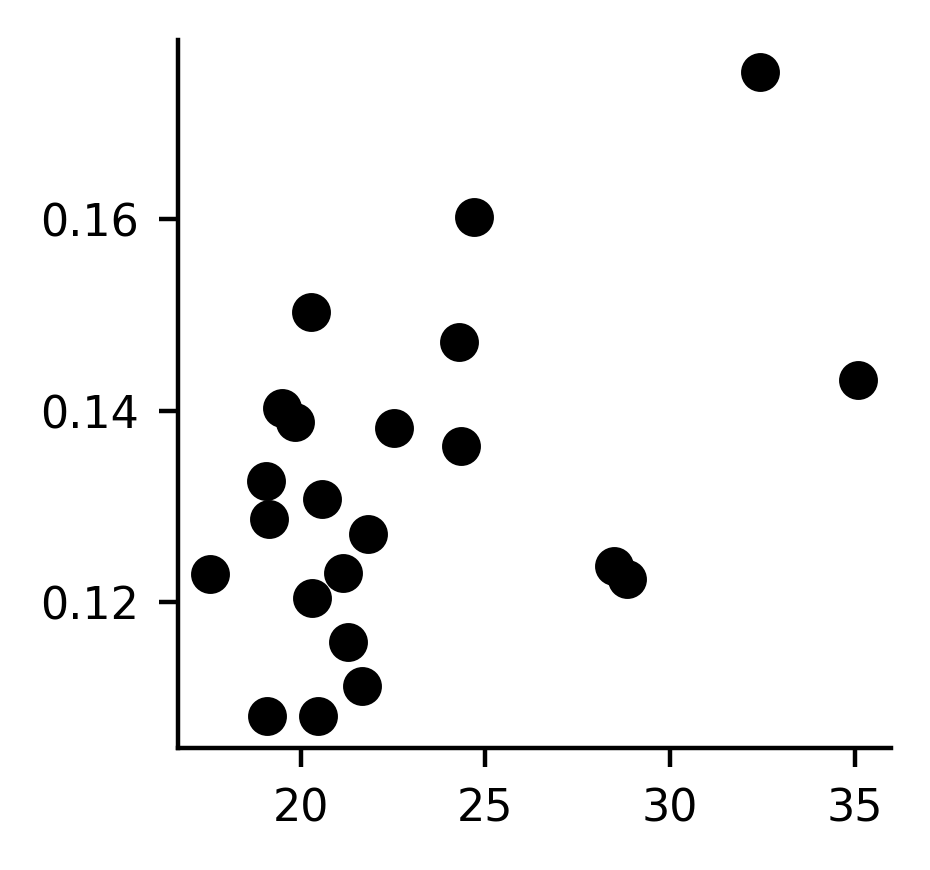

In [27]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'lense diameter (stack)'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel(r'$\rho$ (degrees)')
ax.set_ylabel("Diopteric power ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

/Users/nchua/src/cx-analysis/cx_analysis/vis/fig_tools.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clist = np.array([min_colour, max_colour])


lense diameter (stack)
lense thickness
cone length (from the tip)
cone width (under the lense tip)
D rhabdom dist.
D rhabdom prox.
Mean Microv. Ang. Turn
rhabdom_len
radius_in
radius_out
lens_thickness
f
f-image
P
F-number
rho_l
rho_rh
rho
S


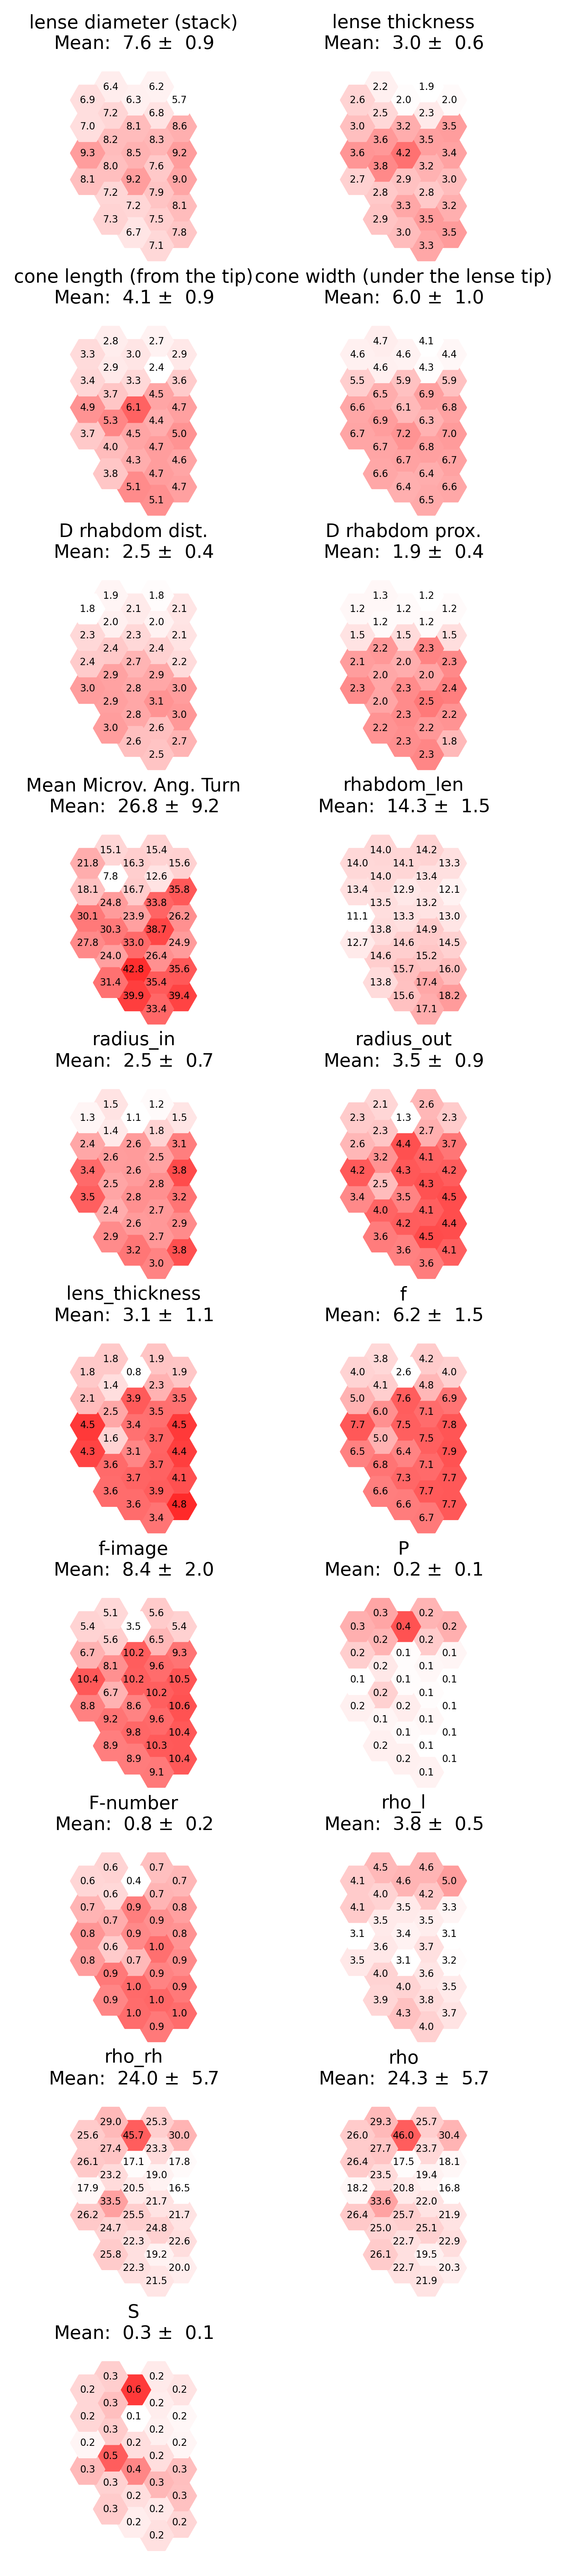

In [25]:
fig, ax = plt.subplots(10, 2, figsize=(4.6, 9.0*2.6))
axes = ax.flatten()
lincm = linear_cmap(n_vals=100, max_colour='r')

param_labels = ['D, facet diameter ($\mu{m}$)', 'l, lens thickness ($\mu{m}$)', '$r_1$, outer curvature ($\mu{m}$)',
               '$r_2$, inner curvature ($\mu{m}$)', 'Cone length ($\mu{m}$)', 'Cone width ($\mu{m}$)', '$D_{Rh}$, Dist. rhab diameter ($\mu{m}$)', 
               'Prox. rhab diameter ($\mu{m}$)', 'Rhabdom length ($\mu{m}$)', 'f, object focal length ($\mu{m}$)', "f', image focal length ($\mu{m}$)",
               'Dioptric power', 'F-number', 'Acceptance angle Rh (degrees)', 'Acceptance angle L, (degrees)', 'Acceptance angle, (degrees)', 
               'S, Optical sensitivity ($\mu{m}^2 sr$)']

param_labels = ['D, facet diameter ($\mu{m}$)', 'l, lens thickness ($\mu{m}$)', 'Cone length ($\mu{m}$)', 'Cone width ($\mu{m}$)', '$D_{Rh}$, Dist. rhab diameter ($\mu{m}$)', 
               'Prox. rhab diameter ($\mu{m}$)', 'Rhabdom length ($\mu{m}$)', 'f, object focal length ($\mu{m}$)', "f', image focal length ($\mu{m}$)",
               'Dioptric power', 'F-number', 'Acceptance angle Rh (degrees)', 'Acceptance angle L, (degrees)', 'Acceptance angle, (degrees)', 
               'S, Optical sensitivity ($\mu{m}^2 sr$)']


i = 0
for param, vals in optics_df.iteritems():
    if param == 'region':
        continue
    print(param)
    max_val = vals.max()
    min_val = vals.min()
    
    node_data = {om: {'label': np.round(v, decimals=1),
                      'colour': lincm((v-min_val)/max_val)} for om, v in vals.items()}
    hexplot(node_data, ax=axes[i])
    axes[i].set_title(f"{param}\n" + 
                      f"Mean: {vals.mean(): .1f} $\pm$ {vals.std(ddof=0): .1f}")
    i += 1
axes[-1].set_visible(False)
plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.png')